<a href="https://colab.research.google.com/github/momoh127/EC414-MachineLearningWork/blob/main/EC414_HW9_fall24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 9 Introduction to PyTorch

**Due date**: TO BE UPDATED, 11:59pm

This homework will introduce you to [PyTorch](https://pytorch.org), currently the fastest growing deep learning library, and the one we will use in this course.

You might find refering to the following tutorial being helful for learning PyTorch and completing the assignmnet:

*   [60-minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)

The tutorial has 4 parts, roughly speaking: question 1, 2 expects the knoweledge of the first two tutorials. Question 3 requires a good grasp of all 4 tutorials. The general structure of the homework is to 'automize' backpropagation tasks implemented in homework 8: instead of deriving and implementing backpropagation from scratch, we shall see the power of `torch.autograd`. You can also check your output against homework 8.



In [1]:
import torch

## Question 1: Simple function with PyTorch (15 pts)

`torch.tensor` is a data structure to store data and parameters. We often set `requires_grad=True` when we create a `torch.tensor` if we want to compute gradient with respect to it. (There are situations that we perfer to set `requires_grad=False` to save computation time and memory).

`autograd` is library included in pytorch that collects gradients for a `torch.Tensor` with `requires_grad=True`.

Here we will explore backpropagation on the simple functions with `torch.tensor` and `tensor.autograd`. Note that it actually unusual to directly call `autograd` functionality: pytorch provides wrappers that hide it from the user.


####1.1. Create Tensors (5pts)


Create and print three `torch.tensors` with values $x=-2$, $y=5$ and $z=-4$, store each of them as `x`, `y` and `z`, respectively, and set `requires_grad=True` to each of them.

In [2]:
### --code required-- ##
x = torch.tensor(-2.0, requires_grad=True)
y = torch.tensor(5.0, requires_grad=True)
z = torch.tensor(-4.0, requires_grad=True)


#end of code here
print(x, y, z)

tensor(-2., requires_grad=True) tensor(5., requires_grad=True) tensor(-4., requires_grad=True)


####1.2. Build Computation Graph (5pts)
The following is a computation graph for the function $f(x,y,z) = (x+y) \times z$.

The round nodes are input variables, the square nodes represents arithmetic operators, the diamond node represents the output of the function. We have labeled one edge as $q$ to indicate the $q$ should represent the intermediate value $x+y$ in the computational graph.  


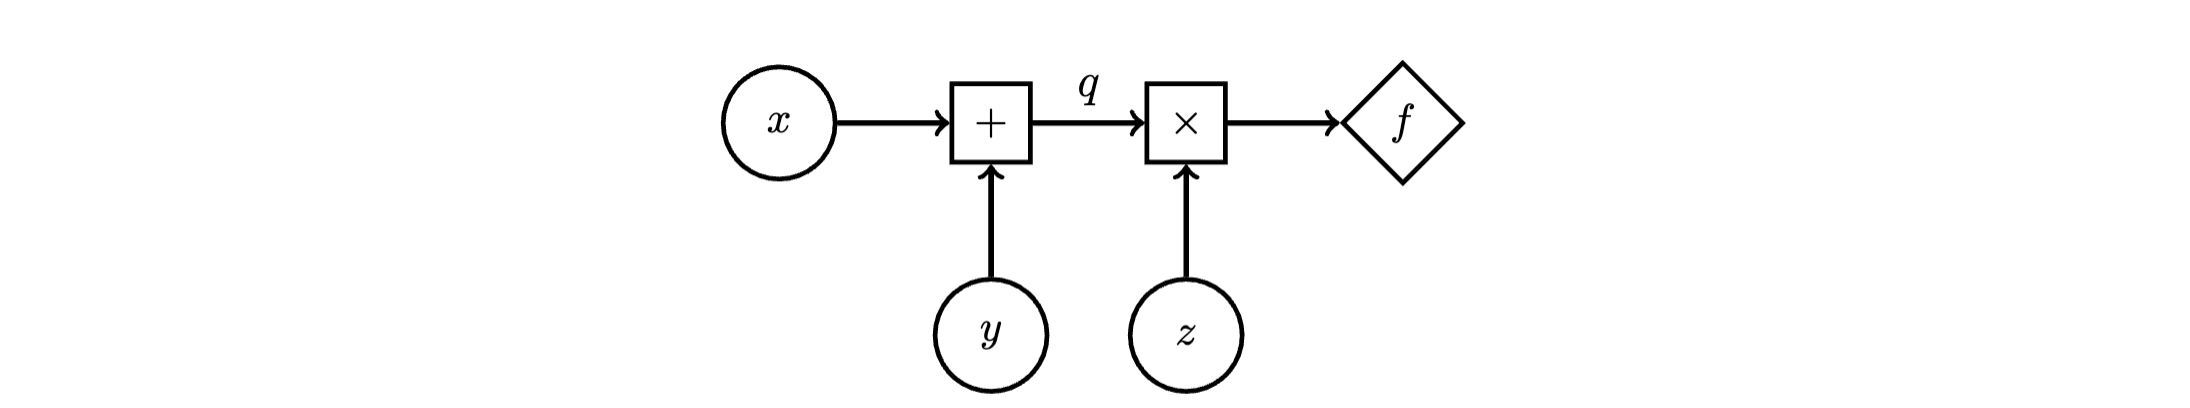


1.   Complete function `simple_fct()`: which takes in `x` `y`, `z` created above, and returns `q` and `f`. Whenever function `simple_fct()` is called, this will 'communicate' with `autograd` to construct the above computational graph for you.

2.   Print $q,f$. (for each of the printed variables, there are two attributes that will be printed. The first is the actual numerical value. The second one should tell the function that you are taking derivative from).

3.   Run `f.backward()`: this will compute the gradients of function $f$ w.r.t. $x,y,z$, respectively.

4.   Print gradients: $f$ w.r.t. $x,y,z,q$. Note that the gradient for $q$ will be `None`. This is because $q$ is an intermediate value in the graph. Pytorch assumes (correctly) that most users do not actually need the gradients for intermediate values, and so will free the associated memory to save space. (Side information: to access gradients for intermediate nodes in PyTorch you can use hooks as mentioned in [this answer](https://discuss.pytorch.org/t/why-cant-i-see-grad-of-an-intermediate-variable/94/2).)

In [3]:
def simple_fct(x, y, z):
    ### --code required-- ##
    q = x + y
    f = q * z

    #end of code here
    return q, f

q, f = simple_fct(x, y, z)
print(q, f)
f.backward()
print(x.grad, y.grad, z.grad, q.grad)

tensor(3., grad_fn=<AddBackward0>) tensor(-12., grad_fn=<MulBackward0>)
tensor(-4.) tensor(-4.) tensor(3.) None


<ipython-input-3-dafc6c7170f5>:12: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  print(x.grad, y.grad, z.grad, q.grad)


####1.3. clear up the gradients for tensors (5pts)
Run the following cell and observe how gradients changes at each iteration: at each iteration gradients are added to their previous values. This is not desired since the gradient stored in a tensor is no longer correct. This is sometimes handy but for now, we want to avoid this from happening.

In [4]:
for t in range(3):
    q, f = simple_fct(x, y, z)
    f.backward()
    print(x.grad, y.grad, z.grad)

tensor(-8.) tensor(-8.) tensor(6.)
tensor(-12.) tensor(-12.) tensor(9.)
tensor(-16.) tensor(-16.) tensor(12.)


To avoid this from happening, we need to use `x.grad.zero_()` 'clear up' the previously stored gradient for a `x` each time before we call `simple_fct()`. Similarly for the other variables.

Add `x.grad.zero_()`, similarly for `y`, `z` inside the loop. This will allow the printed gradients w.r.t. $x,y, z$ remains the same (as the correct values) at each iteration.

That is, make modifications to the loop in the previous cell to have the printed gradients NOT change between iterations.

In [5]:
for t in range(3):
    ### --code required-- ##
    if x.grad is not None:
        x.grad.zero_()
    if y.grad is not None:
        y.grad.zero_()
    if z.grad is not None:
        z.grad.zero_()


    #end of code here
    q, f = simple_fct(x, y, z)
    f.backward()
    print(x.grad, y.grad, z.grad)
    print(x.grad, y.grad, z.grad)

tensor(-4.) tensor(-4.) tensor(3.)
tensor(-4.) tensor(-4.) tensor(3.)
tensor(-4.) tensor(-4.) tensor(3.)
tensor(-4.) tensor(-4.) tensor(3.)
tensor(-4.) tensor(-4.) tensor(3.)
tensor(-4.) tensor(-4.) tensor(3.)


## Question 2. Function with Vectors/Matrices Inputs (25 pts)

In machine learning, most of mathematical operation are done on vectors / matrices. We will experiment with functions that takes vectors as inputs.
Now, we explore function with vectors/matrices inputs and computing their gradients.

#### 2.1. A Handy Short Cut (5pts)

Consider a function $g: \mathbb{R} \mapsto \mathbb{R}$:
$$g(x) = \frac{1}{1 + \exp( - x ) }$$

What is the name given to $g$ in the context of activation function in neural networks?
Look up and write the name of the corresponding function call in pytorch for $g$ (for example, if $g$ where the exponential function, you would write `torch.exp`).

**solution**:

Sigmoid function. `torch.sigmoid()`

#### 2.2 Autograd (5pts)

In this question you will write pytorch code for the function $$g(\mathbf{w}^T \mathbf{x}) = \frac{1}{1 + \exp( - \mathbf{w}^T \mathbf{x}) }$$ by:


1.   Initialize $\mathbf{x} =[-1, -2, 1]$ and $ \mathbf{w}=[2, -3, -3]$ as `torch.tensors`.
2.   Create a new tensor $z = \mathbf{w}^T \mathbf{x}$.
3.   Compute $g(z)$ and store it inn a new tensor object `g` (You can use the function identified from the previous question as a short cut).

Set `requires_grad = True` to appropriate variables, and print out the value $g$ and the gradients of $g$ w.r.t. $\mathbf{w}, \mathbf{x}$, respectively.

Side notes: just like `np.matmul` does matrix multiplication, we have `torch.matmul` for tensors does the same job. And many other mathematical operations we had in `numpy`. Almost any functions you encontered in `numpy` has a cooresponding `tensor` version.



In [6]:
# initialize and print g
### --code required-- ##
x = torch.tensor([-1.0, -2.0, 1.0], requires_grad=True)
w = torch.tensor([2.0, -3.0, -3.0], requires_grad=True)

z = torch.matmul(w, x)

g = torch.sigmoid(z)


# end of code here
print(f'x = {x}\nw = {w}\ng(x, w)={g}')

# compute and print gradients
### --code required-- ##
g.backward()

# end of code here

print(f'The gradient of g() w.r.t. w is {w.grad}')
print(f'The gradient of g() w.r.t. x is {x.grad}')


x = tensor([-1., -2.,  1.], requires_grad=True)
w = tensor([ 2., -3., -3.], requires_grad=True)
g(x, w)=0.7310585975646973
The gradient of g() w.r.t. w is tensor([-0.1966, -0.3932,  0.1966])
The gradient of g() w.r.t. x is tensor([ 0.3932, -0.5898, -0.5898])


#### 2.3. Blocks/Layers in torch.nn (15pts)

In deep learning, we often reuse use the same functions, such as activation functions, loss functions, linear layers that can be connected into a neural network. We do not write each of them from scratch. These commonly used functions and building blocks are implemented in `torch.nn`.

Using `torch.nn`, build the following model:
\begin{align*}
g(\mathbf{x}, \mathbf{w}, b) = \frac{1}{1 + \exp( - (\mathbf{w}^T \mathbf{x} + b ) ) }
\end{align*}
In the context of machine learning, you can interpret $\mathbf{x}$ as the input data, $ \mathbf{w}$ as the weight, $b$ as the bias.
A building block to represent $\mathbf{w}^T \mathbf{x} + b$ is so called linear layer: `torch.nn.Linear()`.

1.   Using `torch.nn.Linear`, build the above model with weights to $\mathbf{w}=[2, -3]$ and bias $b=-3$ (you will need to look up how to change the weights of the linear layer from pytorch default random initialization).
2.   Initialize a data $\mathbf{x}=[-1, -2]$ (you don't need to set `requires_grad=True` for $\mathbf{x}$ because in the context of machine learning, we usually do not require gradient with respect to data), and print the value of $g$
3.   Compute $\frac{\partial g}{\partial \mathbf{w}}, \frac{\partial g}{\partial b}$ and print each of them out.

Side Notes: we build an equivalant model with question 2.2, since it was equivlent to $\mathbf{x} \mapsto [\mathbf{x},1], \mathbf{w} \mapsto [\mathbf{w}, b]$. So the outout should match.



In [7]:
import torch.nn as nn

# linear layer
### --code required-- ##
linear = nn.Linear(2, 1)  # Input dimension: 2, Output dimension: 1

linear.weight = nn.Parameter(torch.tensor([[2.0, -3.0]]))
linear.bias = nn.Parameter(torch.tensor([-3.0]))


# end of code here

print("\nweights:", linear.weight)
print("\nbias:",linear.bias)

# initialize data and print output
### --code required-- ##
x = torch.tensor([-1.0, -2.0])

z = linear(x)
g = torch.sigmoid(z)

# end of code here


print("\ng:", g)

# compute and print gradient
### --code required-- ##
g.backward()

# end of code here

print("The gradient of g() w.r.t. w, b are", linear.weight.grad, linear.bias.grad)


weights: Parameter containing:
tensor([[ 2., -3.]], requires_grad=True)

bias: Parameter containing:
tensor([-3.], requires_grad=True)

g: tensor([0.7311], grad_fn=<SigmoidBackward0>)
The gradient of g() w.r.t. w, b are tensor([[-0.1966, -0.3932]]) tensor([0.1966])


## Question 3: A Simple Neural Network (45 pts)
After familiarizing basic functionalities of `tensors`, `autograd`, `torch.nn`, we will build and train a simple multi layer perceptron, this model will resemble HW8 question 2.

Assuming a good understanding of first two tutorials, you will roughly need the third tutorial for 3.1-3.5 (https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html),
 and the forth one for the remaining questions.


#### 3.0. DataLoading

Neural networks are often training with batch gradient methods (such as, batch stochastic gradient descent). We need to seperate data into batches, here we are using the same MNIST data set, that is a set of 28 by 28 grey images.

In PyToch, we load data and seperate them into batches using the following functions. Here we used batch size = 64. All data are already flattened and target are one-hot-encoded.


In [8]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F # contains commonly used functions

# Training data
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=ToTensor())
train_data = (train_dataset.data/255).float().view(-1, 784)
train_target = F.one_hot(train_dataset.targets, num_classes=10).float()

# Testing data
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=ToTensor())
test_data = (test_dataset.data/255).float().view(-1, 784)
test_target = F.one_hot(test_dataset.targets, num_classes=10).float()

# split batch
train_dataloader = torch.utils.data.DataLoader([*zip(train_data, train_target)], batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader([*zip(test_data, test_target)], batch_size=64, shuffle=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 489kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.37MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.08MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#### 3.1. Model Structure (10pts)
In this question you will build a similar model to the one used in HW8 question 2. The model takes in data with input dimesion as $784$, and output dimension as $10$. The model is transforms the input data as follows (arrows between different dimensionalities indicate linear layers):
$$\mathbf{R}^{784} \rightarrow  \mathbf{R}^{256} \rightarrow ReLU \rightarrow \mathbf{R}^{128} \rightarrow ReLU  \rightarrow \mathbf{R}^{10} \rightarrow Softmax^{\ast} \rightarrow Output \in \mathbb{R}^{10} $$

Write a subclass of the `nn.Module` class called `MLP`.
You will need to define
1.    `__init__()` method: class object constructor, initialize any thing required to build the model
2.    `forward()` method: given input data, compute and return the output

$^\ast$: The difference in HW8 was we used sigmoid instead of softmax as it is easier to implement the derivative of the sigmoid. The softmax is a variation on the sigmoid that is used for multiclass classification tasks.

In [9]:
class MLP(nn.Module):

    # constructor:
    def __init__(self):
        # initialize parents class
        super().__init__()
        # initialize `Model` building blocks, parameter:
        ### --code required-- ##
        self.layer1 = nn.Linear(784, 256)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(128, 10)
        self.softmax = nn.Softmax(dim=1)


        # end of code here

    # feed forward: given an input, return output
    def forward(self, x):
        ### --code required-- ##
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.layer3(x)
        x = self.softmax(x)
        return x

        # end of code here


Initialize a instance of `MLP` as variable named `model`.

Print `model`: this shows you how dimension changes at each layer

The "trainable pameters" of the model (i.e. the weights and biases of the  linear layers) are stored as a list and can be accessed by calling `model.parameters()`. Print the shape of each trainable parameters and check whether the dimension is what you are expecting.

In [10]:
model = MLP()
print(model)

for params in model.parameters():
    print(params.shape) # these are all parameters in the order of weights, bias, ...,

MLP(
  (layer1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (layer3): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)
torch.Size([256, 784])
torch.Size([256])
torch.Size([128, 256])
torch.Size([128])
torch.Size([10, 128])
torch.Size([10])


In [11]:
# This cell is not for credit but help you to check the expected input output dimension of the network:

Batch_size = 64
# this a dummy batch data [64, 784]
input = torch.rand(Batch_size, 784)
output = model(input)

print(output.shape)

torch.Size([64, 10])


#### Loss Function


Suppose we want to train `model` using mean squared error. Find the correspondng loss function from `torch.nn`, and declare an object `criterion` representing mean sequare error loss.


In [12]:
criterion = nn.MSELoss()

#### 3.2. Choose an Optimizer (5pts)

Frequently used iterative optimization algorithms can be imported from `torch.optim`.

We studied gradient descent, batch stochastic gradient descent, stochastic gradient descent. All of these can be achieved by a single optimizer from this library. Find the one can accompolish batch stochastic gradient descent, initialize an instance stores as `optimizer` and set learning rate as `1`. You can leave other parameters as their default values.

 `optimizer` will be used to do backprop on all trainable parameters from `model`.


In [13]:
### --code required-- ##
import torch.optim as optim

### --code required-- ##
optimizer = optim.SGD(model.parameters(), lr=1)

# end of code here

#### 3.3. Model Training and Evaluation (30pts)

Complete  `eval_acc():`


In [14]:
def eval_acc(out, target):
    '''
    Returns the percentage of correctly classified example in a batch with batch size B.

    params:
      out: output from model [B,10]
      target: one-hot-encoded true labels [B, 10]
    returns:
      accuracy: accuracy in percentage
    '''
    ### --code required-- ##
    pred = out.argmax(dim=1)
    true = target.argmax(dim=1)
    correct = (pred == true).sum().item()
    accuracy = (correct / target.size(0)) * 100


    # end of code here

    return accuracy

Complete `train():`

A excellent reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html



In [23]:
def train(model, data_loader, criterion, optimizer, epoch):
    '''
    Performs model training over specified number of epochs.
    During your training loop, you might need to include `optimizer.zero_grad()`
    somewhere to 'clear up' the stored gradients from previous iteration.

    params:
      model: an instance of `MLP` to be trained
      data_loader: an object which stores data in batches
      criterion: an object of the chosen loss function
      optimizer: an object of the chosen optimizer which optimizes all the trainable parameters in `model`
      epoch: number of training epoch

    returns:
      ls_list: losses at every opoch
      acc_list: accuracies at every epoch
    '''
    ### --code required-- ##
    ls_list = []
    acc_list = []

    for e in range(epoch):
        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for inputs, targets in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            predictions = outputs.argmax(dim=1)
            true_labels = targets.argmax(dim=1)
            correct_predictions += (predictions == true_labels).sum().item()
            total_samples += targets.size(0)

        avg_loss = total_loss / len(data_loader)
        accuracy = (correct_predictions / total_samples) * 100

        ls_list.append(avg_loss)
        acc_list.append(accuracy)

        print(f"Epoch {e + 1}/{epoch}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")



    # end of code here

    return ls_list, acc_list


Complete the function `testing():`

For testing purpose, we do not need backpropogation hence we no longer need `requires_grad = True` for all the trainable parameters. The python context manager `with torch.no_grad(): ` will temporarily turn off gradients tracking within the function, which is a good practice whenever in writing a testing function.

In [24]:
def testing(model, data_loader, criterion):
    '''
    computes loss and accuracy for a trained model of the entire dataset in data_loader.

    params:
      model: a trained instance of `MLP`
      data_loader: an object which stores dataset in batches
      criterion: an object of the chosen loss function

    returns:
      loss_val: the loss value
      acc_val: the accuracy value in percentage
    '''
    with torch.no_grad():
    ### --code required-- ##
      model.eval()
      total_loss = 0.0
      correct_predictions = 0
      total_samples = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item()

            predictions = outputs.argmax(dim=1)
            true_labels = targets.argmax(dim=1)
            correct_predictions += (predictions == true_labels).sum().item()
            total_samples += targets.size(0)

    loss_val = total_loss / len(data_loader)
    acc_val = (correct_predictions / total_samples) * 100



    # end of code here
    return loss_val, acc_val

Run the following cell to train your model with training dataset for 20 epoch, and plot training loss, accuracy for each epoch:

Epoch 1/20, Loss: 0.0396, Accuracy: 74.21%
Epoch 2/20, Loss: 0.0127, Accuracy: 91.72%
Epoch 3/20, Loss: 0.0098, Accuracy: 93.74%
Epoch 4/20, Loss: 0.0079, Accuracy: 95.03%
Epoch 5/20, Loss: 0.0066, Accuracy: 95.88%
Epoch 6/20, Loss: 0.0056, Accuracy: 96.51%
Epoch 7/20, Loss: 0.0048, Accuracy: 97.04%
Epoch 8/20, Loss: 0.0042, Accuracy: 97.42%
Epoch 9/20, Loss: 0.0037, Accuracy: 97.77%
Epoch 10/20, Loss: 0.0033, Accuracy: 98.05%
Epoch 11/20, Loss: 0.0030, Accuracy: 98.22%
Epoch 12/20, Loss: 0.0027, Accuracy: 98.42%
Epoch 13/20, Loss: 0.0025, Accuracy: 98.55%
Epoch 14/20, Loss: 0.0023, Accuracy: 98.69%
Epoch 15/20, Loss: 0.0021, Accuracy: 98.87%
Epoch 16/20, Loss: 0.0019, Accuracy: 98.96%
Epoch 17/20, Loss: 0.0017, Accuracy: 99.07%
Epoch 18/20, Loss: 0.0016, Accuracy: 99.15%
Epoch 19/20, Loss: 0.0015, Accuracy: 99.23%
Epoch 20/20, Loss: 0.0014, Accuracy: 99.28%


Text(0.5, 1.0, 'training accuracy')

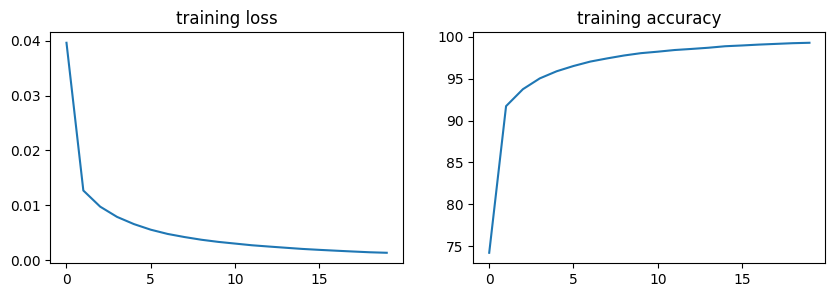

In [25]:
import matplotlib.pyplot as plt

ls_list, acc_list = train(model, train_dataloader, criterion, optimizer, 20)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.plot(ls_list)
ax1.set_title('training loss')
ax2.plot(acc_list)
ax2.set_title('training accuracy')

test the trained `model` with testing dataset and print the testing loss and accuracy:

In [26]:
import matplotlib.pyplot as plt
test_ls, test_acc = testing(model, test_dataloader, criterion)
print('testing loss', test_ls, ' accuracy:', test_acc)

testing loss 0.0033925249601429205  accuracy: 97.83
